In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import helpers as hp

In [3]:
tf.get_logger().setLevel(logging.ERROR)

In [4]:
commands, nums = hp.get_commands_dict('commands.csv')

In [5]:
all_speakers = ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
dataset = dict()
for speaker in all_speakers:
    data = hp.load_from_datafile(f'data/{speaker}_data.npy')
    labels = hp.load_from_datafile(f'data/{speaker}_labels.npy')

    data = data.reshape(data.shape + (1,))
    labels = to_categorical([hp.get_num_by_command(label, commands) for label in labels], num_classes=11)
    idx = np.random.permutation(data.shape[0])
    data, labels = data[idx], labels[idx]
    
    dataset[speaker] = {
        'data':   data,
        'labels': labels 
    }
    
    print(f'{speaker} data shape: {dataset[speaker]["data"].shape}')
    print(f'{speaker} labels shape: {dataset[speaker]["labels"].shape}')

speaker1 data shape: (550, 400, 13, 1)
speaker1 labels shape: (550, 11)
speaker2 data shape: (440, 400, 13, 1)
speaker2 labels shape: (440, 11)
speaker3 data shape: (440, 400, 13, 1)
speaker3 labels shape: (440, 11)
speaker4 data shape: (440, 400, 13, 1)
speaker4 labels shape: (440, 11)
speaker5 data shape: (550, 400, 13, 1)
speaker5 labels shape: (550, 11)
speaker6 data shape: (550, 400, 13, 1)
speaker6 labels shape: (550, 11)


In [6]:
test_size = 0.3
cnn_test_summary = []
mlp_test_summary = []
threshold_list = [0.5, 0.6, 0.7, 0.8]

In [7]:
def run_experiment(train_list, test_list, train_list_shortname, nn_type, threshold_list, plot_cm=True, plot_model=False):
    print(f'Running experiment with speakers : {train_list} as train dataset and speakers : {test_list} as test dataset.',
          f'Network type is {nn_type}.')
    # Set train data
    train_data = []
    train_labels = []
    for speaker in train_list:
        train_data.append(dataset[speaker]['data'][:np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int), ...])
        train_labels.append(dataset[speaker]['labels'][:np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int), ...])
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    
    # Set test data
    test_data = []
    test_labels = []
    test_dict = dict()
    for speaker in test_list:
        test_data.append(dataset[speaker]['data'][np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int):, ...])
        test_labels.append(dataset[speaker]['labels'][np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int):, ...])
        test_dict[speaker] = {
            'data': dataset[speaker]['data'][np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int):, ...] ,
            'labels': dataset[speaker]['labels'][np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int):, ...]
        }
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
        
    print('---Train dataset---')
    print(f'Contains speakers : {train_list}')
    print(f'data shape : {train_data.shape}')
    print(f'labels shape : {train_labels.shape}')
    
    print('---Test dataset---')
    print(f'Contains speakers : {test_list}')
    for speaker in test_list:
        print(f'{speaker} data shape : {test_dict[speaker]["data"].shape}')
        print(f'{speaker} labels shape : {test_dict[speaker]["labels"].shape}')
    
    # Train
    if nn_type == 'mlp':
        model = hp.get_mlp_model()
        if plot_model:
            tf.keras.utils.plot_model(model, to_file='article/img/mlp_model.png', show_shapes=True)
    elif nn_type == 'cnn':
        model = hp.get_cnn_model()
        if plot_model:
            tf.keras.utils.plot_model(model, to_file='article/img/cnn_model.png', show_shapes=True)
        
#     model.summary()
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint_best_only = ModelCheckpoint(save_freq='epoch', save_best_only=True,
                                           filepath='model_checkpoints/experiment2/' + nn_type + '/best_only', verbose=0) 
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0)

    print('---Training stage---')
    history = model.fit(train_data, train_labels, epochs=50, batch_size=256, validation_split=0.15, 
                        callbacks=[early_stopping, checkpoint_best_only], 
                        verbose=0)

    hp.plot_metrics(history)
    
    # Test
    print('---Testing stage---')
    for speaker in test_list:
        test_loss, test_accuracy = model.evaluate(test_dict[speaker]['data'], test_dict[speaker]['labels'], verbose=0)
        print(f"{speaker} - test loss : {test_loss:0.3f} - test accuracy : {test_accuracy:0.3f}")
        
        if nn_type == 'cnn':
            cnn_test_summary.append([train_list_shortname, speaker, round(test_loss, 3), round(test_accuracy, 3)])   
        else:
            mlp_test_summary.append([train_list_shortname, speaker, round(test_loss, 3), round(test_accuracy, 3)])        
#         print('-'*10)
    
    if plot_cm:
        cm_arr = list()
        for threshold in threshold_list:
            cm_arr.append({
                'cm': hp.get_confusion_matrix(test_labels, model.predict(test_data), nums, threshold=threshold), 
                'threshold': threshold
            })
        hp.plot_confusion_matrix(cm_arr)
    
    print('Finished experiment.')
    print('='*10)       

Running experiment with speakers : ['speaker1'] as train dataset and speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as test dataset. Network type is cnn.
---Train dataset---
Contains speakers : ['speaker1']
data shape : (385, 400, 13, 1)
labels shape : (385, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 data shape : (132, 400, 13, 1)
speaker3 labels shape : (132, 11)
speaker4 data shape : (132, 400, 13, 1)
speaker4 labels shape : (132, 11)
speaker5 data shape : (165, 400, 13, 1)
speaker5 labels shape : (165, 11)
speaker6 data shape : (165, 400, 13, 1)
speaker6 labels shape : (165, 11)
---Training stage---


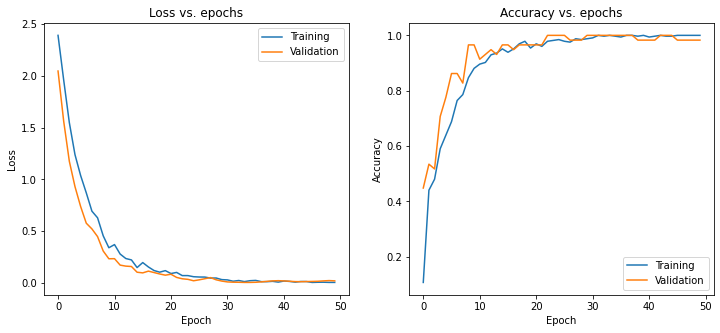

---Testing stage---
speaker1 - test loss : 0.082 - test accuracy : 0.976
speaker2 - test loss : 10.499 - test accuracy : 0.136
speaker3 - test loss : 7.026 - test accuracy : 0.242
speaker4 - test loss : 10.057 - test accuracy : 0.159
speaker5 - test loss : 3.252 - test accuracy : 0.570
speaker6 - test loss : 18.258 - test accuracy : 0.152
Finished experiment.
Running experiment with speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5'] as train dataset and speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as test dataset. Network type is cnn.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5']
data shape : (1694, 400, 13, 1)
labels shape : (1694, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 label

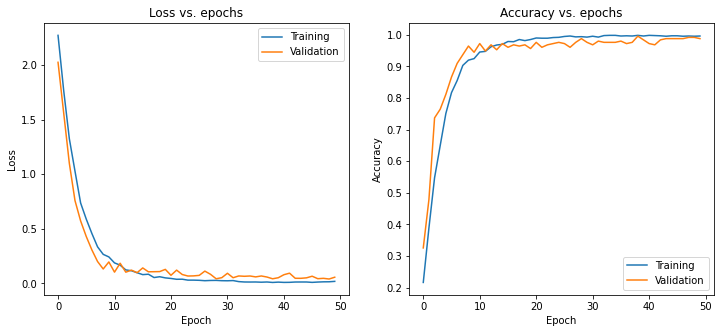

---Testing stage---
speaker1 - test loss : 0.030 - test accuracy : 0.994
speaker2 - test loss : 0.126 - test accuracy : 0.977
speaker3 - test loss : 0.100 - test accuracy : 0.977
speaker4 - test loss : 0.387 - test accuracy : 0.947
speaker5 - test loss : 0.117 - test accuracy : 0.970
speaker6 - test loss : 12.452 - test accuracy : 0.303
Finished experiment.
Running experiment with speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as train dataset and speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as test dataset. Network type is cnn.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
data shape : (2079, 400, 13, 1)
labels shape : (2079, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400,

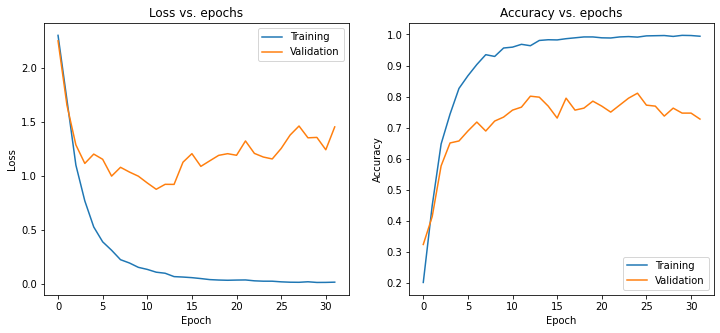

---Testing stage---
speaker1 - test loss : 0.046 - test accuracy : 0.988
speaker2 - test loss : 0.139 - test accuracy : 0.977
speaker3 - test loss : 0.089 - test accuracy : 0.985
speaker4 - test loss : 0.291 - test accuracy : 0.955
speaker5 - test loss : 0.101 - test accuracy : 0.988
speaker6 - test loss : 1.810 - test accuracy : 0.727


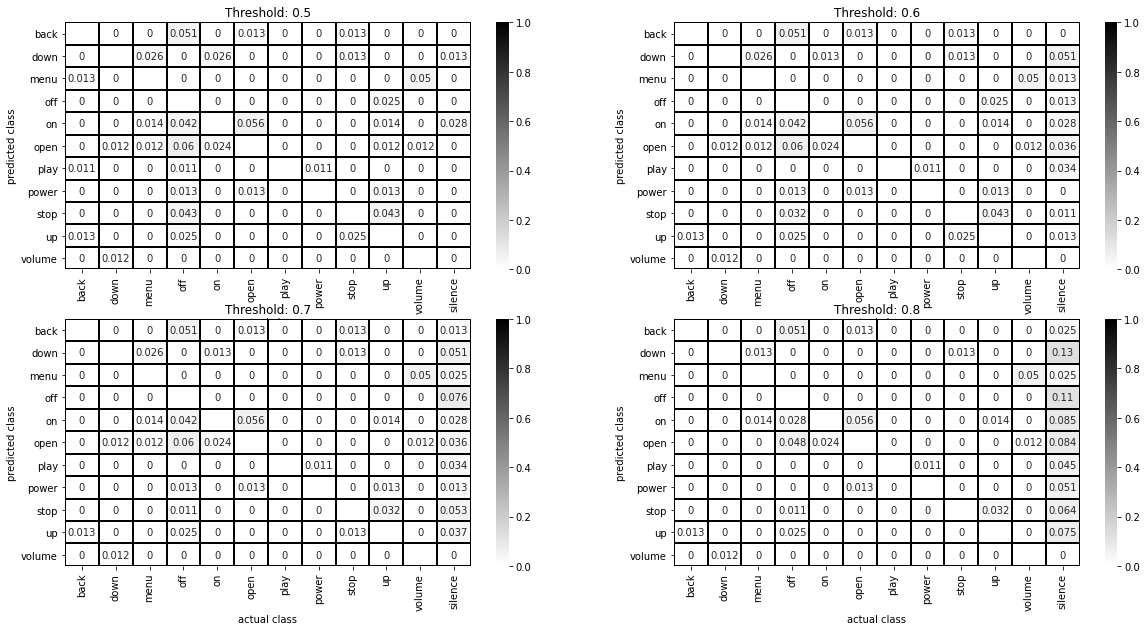

Finished experiment.
Running experiment with speakers : ['speaker1'] as train dataset and speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as test dataset. Network type is mlp.
---Train dataset---
Contains speakers : ['speaker1']
data shape : (385, 400, 13, 1)
labels shape : (385, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 data shape : (132, 400, 13, 1)
speaker3 labels shape : (132, 11)
speaker4 data shape : (132, 400, 13, 1)
speaker4 labels shape : (132, 11)
speaker5 data shape : (165, 400, 13, 1)
speaker5 labels shape : (165, 11)
speaker6 data shape : (165, 400, 13, 1)
speaker6 labels shape : (165, 11)
---Training stage---


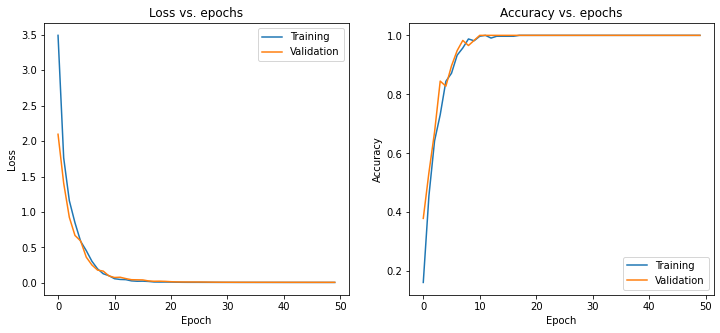

---Testing stage---
speaker1 - test loss : 0.121 - test accuracy : 0.982
speaker2 - test loss : 9.119 - test accuracy : 0.159
speaker3 - test loss : 2.868 - test accuracy : 0.348
speaker4 - test loss : 6.561 - test accuracy : 0.227
speaker5 - test loss : 3.363 - test accuracy : 0.552
speaker6 - test loss : 9.450 - test accuracy : 0.164
Finished experiment.
Running experiment with speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5'] as train dataset and speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as test dataset. Network type is mlp.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5']
data shape : (1694, 400, 13, 1)
labels shape : (1694, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels s

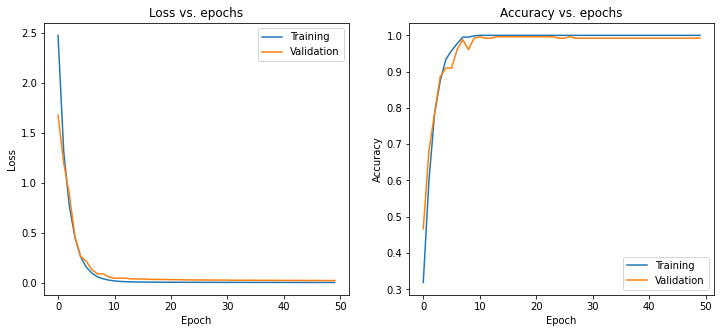

---Testing stage---
speaker1 - test loss : 0.064 - test accuracy : 0.988
speaker2 - test loss : 0.206 - test accuracy : 0.939
speaker3 - test loss : 0.026 - test accuracy : 0.992
speaker4 - test loss : 0.396 - test accuracy : 0.917
speaker5 - test loss : 0.065 - test accuracy : 0.988
speaker6 - test loss : 5.323 - test accuracy : 0.297
Finished experiment.
Running experiment with speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as train dataset and speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as test dataset. Network type is mlp.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
data shape : (2079, 400, 13, 1)
labels shape : (2079, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 

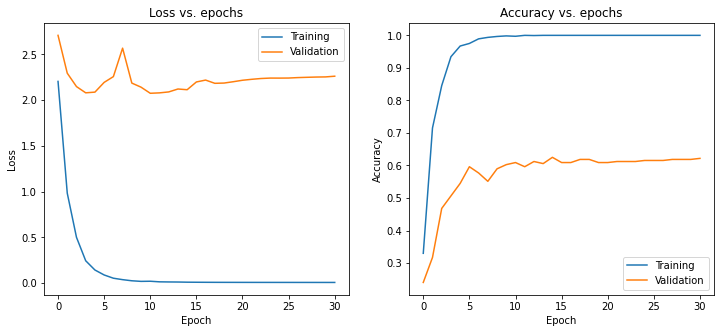

---Testing stage---
speaker1 - test loss : 0.044 - test accuracy : 0.994
speaker2 - test loss : 0.364 - test accuracy : 0.909
speaker3 - test loss : 0.035 - test accuracy : 0.992
speaker4 - test loss : 0.265 - test accuracy : 0.939
speaker5 - test loss : 0.060 - test accuracy : 0.994
speaker6 - test loss : 2.187 - test accuracy : 0.642


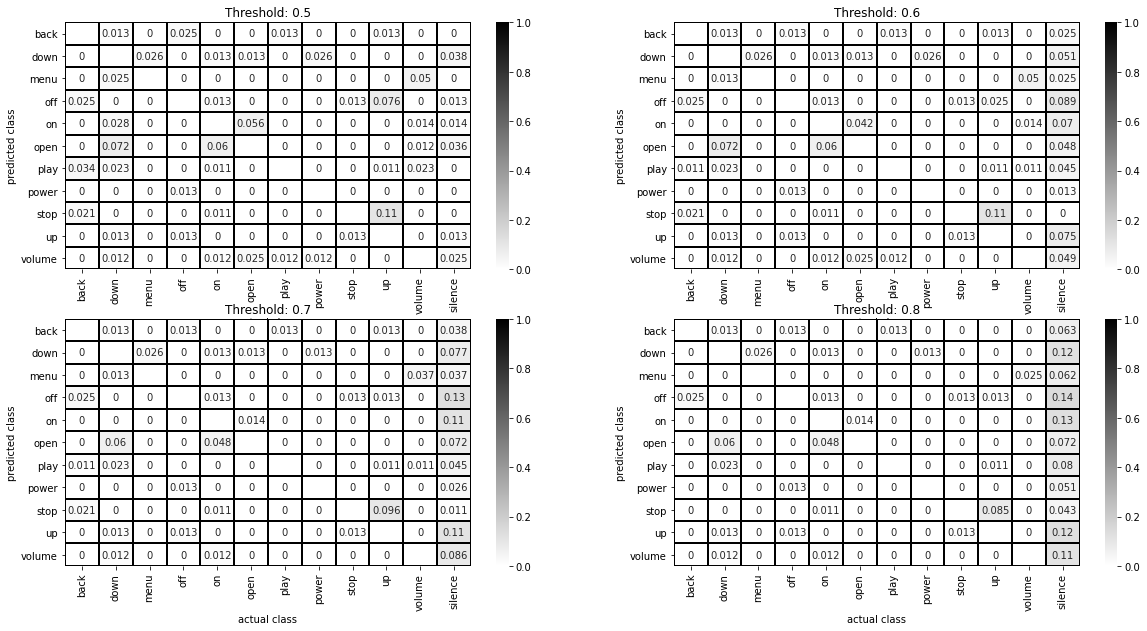

Finished experiment.


In [8]:
for nn_type in ['cnn', 'mlp']:
    run_experiment(['speaker1'], all_speakers, 'speaker1', nn_type, threshold_list, False, True)
    run_experiment(['speaker1','speaker2','speaker3','speaker4','speaker5'], all_speakers, 'all_male_speakers', nn_type, threshold_list, False, False)
    run_experiment(all_speakers, all_speakers, 'all_speakers', nn_type, threshold_list, True, False)

In [9]:
cnn_cols = ['train_data', 'test_speaker', 'cnn_loss', 'cnn_accuracy']
mlp_cols = ['train_data', 'test_speaker', 'mlp_loss', 'mlp_accuracy']

compare_order = ['train_data', 'test_speaker', 'cnn_loss', 'mlp_loss', 'cnn_accuracy', 'mlp_accuracy']
cnn_df = pd.DataFrame(cnn_test_summary, columns=cnn_cols)
mlp_df = pd.DataFrame(mlp_test_summary, columns=mlp_cols)
cols_to_use = mlp_df.columns.difference(cnn_df.columns)
final_df = pd.merge(cnn_df, mlp_df[cols_to_use], left_index=True, right_index=True, how='outer')[compare_order]
pd.set_option('display.max_colwidth', None)
display(final_df)
final_df.to_csv('article/test_summary.csv', index=False)

,train_data,test_speaker,cnn_loss,mlp_loss,cnn_accuracy,mlp_accuracy
0,speaker1,speaker1,0.082,0.121,0.976,0.982
1,speaker1,speaker2,10.499,9.119,0.136,0.159
2,speaker1,speaker3,7.026,2.868,0.242,0.348
3,speaker1,speaker4,10.057,6.561,0.159,0.227
4,speaker1,speaker5,3.252,3.363,0.570,0.552
5,speaker1,speaker6,18.258,9.450,0.152,0.164
6,all_male_speakers,speaker1,0.030,0.064,0.994,0.988
7,all_male_speakers,speaker2,0.126,0.206,0.977,0.939
8,all_male_speakers,speaker3,0.100,0.026,0.977,0.992
9,all_male_speakers,speaker4,0.387,0.396,0.947,0.917
